Animal Welfare Center - 

Prediction of Animal Outcome State, from a Multiclass target column. 
The dataset comprises of Categorical and Numerical Features. Apply Your Furnished feature selection techniques and Modelling of classifiers to predict the state.

![Imgur](https://i.imgur.com/F2FeDI8.png)


![Imgur](https://i.imgur.com/X7uFllL.png)

In [39]:
#DATA LOADING 
import pandas as pd
import numpy as np 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from catboost import Pool, CatBoostClassifier, cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#import pickle---(Check on if to save the model for training again !)
#Loading The DataSet as Train Data and Test Data 
X = pd.read_csv("../input/animalstate-awc/train.csv")
X_test_full = pd.read_csv("../input/animalstate-awc/test.csv")
print("A GLIMPSE OF THE DATA COLUMN TYPES--")
display(X.info())
y = X.outcome_type
X.drop(['outcome_type'], axis=1, inplace=True)

#FEATURE SELECTION OF NUMERIC AND CATEGORICAL COLUMNS -----

Numerical_cols = [col for col in X.columns if X[col].dtype == "int64" or X[col].dtype =="float64"]
X_numeric = X[Numerical_cols]
print("The Following are Numerical Columns : \n",Numerical_cols,sep="\n")

#Columns to be dropped are:- 
     #Dropped                                    -  Categorical Equivalent Columns
#1. age_upon_intake(days),age_upon_intake(years) - [age_upon_intake_age_group]
#2. age_upon_outcome(days), age_upon_outcome(years) -[age_upon_outcome_age_group]

#3. intake_number - outcome_number, Both are Equal, very obvious. Hence dropping one of them

X_numeric.drop(['age_upon_intake_(days)','age_upon_intake_(years)','age_upon_outcome_(days)',
                'age_upon_outcome_(years)','intake_number'],axis=1,inplace=True)

# Print number of unique entries by column, in ascending order
object_nunique = list(map(lambda col: X[col].nunique(), Numerical_cols))
d1 = dict(zip(Numerical_cols, object_nunique))

#print("For Numerical Variables, Unique Values in each Column : ", sorted(d1.items(), key=lambda x: x[1]), sep="\n")
list1 = ['age_upon_intake_(days)','age_upon_intake_(years)','age_upon_outcome_(days)',
                'age_upon_outcome_(years)','intake_number']
print("Numerical Columns to Be dropped are: \n", list1)
print("Numerical Columns Considered for Correlation are : \n")
display( X_numeric.head())

#CATEGORICAL COLUMNS FILETERING
Categorical_cols = [col for col in X.columns if X[col].dtype == "object"]
print("The Following are Categorical Columns : \n",Categorical_cols)

#GETTING THE CATEGORICAL DF READY
X_categorical = X[Categorical_cols]

#CHECKING FOR UNIQUE VALUES IN THE COLUMNS TO CONSIDER CARDINALITY AND HENCE DROP SUCH COLUMNS--
object_nunique = list(map(lambda col: X[col].nunique(), Categorical_cols))
d = dict(zip(Categorical_cols, object_nunique))
# Print number of unique entries by column, in ascending order

#print("For Categorical Variables Unique Value in each column: ", sorted(d.items(), key=lambda x: x[1]), sep ="\n")


#REMOVING AND REPLACING HIGH CARDINALITY CATEGORICAL COLUMNS ---
#Points to be kept in mind :- 
#We will Replace Most of the Categorical Columns with Numeric Ones to Enhace our Label encoding.
#After Dropping the Columns from Here, we will Still Check for correlation, to extract proper Features
#Dropped Columns are categorical data which was just increasing the cardinality. 


#Columns to be Dropped are :-
    #Dropped        Numeric Columns Equivalent
#1. date_of_birth - [dob_year,dob_month]
#2. intake_monthyear, intake_datetime  - [intake_month, intake_year, intake_ hour]
#3. outcome_monthyear, outcome_datetime - [outcome_month, outcome_year, outcome_hour]
#4. time_in-shelter - [time_in_shelter_days]
#5. animal_id_outcome - not considerate in training and correlation
#6. age_upon_intake, age_upon_outcome

X_categorical.drop(["animal_id_outcome","outcome_datetime","intake_datetime",
                    'date_of_birth','intake_monthyear','intake_datetime',
                    'outcome_monthyear','outcome_datetime','time_in_shelter',
                   'age_upon_intake','age_upon_outcome'],axis=1,inplace=True)

list2 = ["animal_id_outcome","outcome_datetime","intake_datetime",
                    'date_of_birth','intake_monthyear','intake_datetime',
                    'outcome_monthyear','outcome_datetime','time_in_shelter',
                   'age_upon_intake','age_upon_outcome']
print("Categorical Columns to Be dropped are : \n", list2)
print("Categorical Columns Considered for Correlation are : \n")
display(X_categorical.head())

#DEFINING LABEL ENCODER -
le = LabelEncoder()

#USING LABEL ENCODER TO ENCODE ALL THE CATEGORICAL COLUMNS NOW--
X_cCodes = X_categorical.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')

#Remark : While label encoding Categorical Columns we will have float like string values,
#hence handle such columns by converting Df columns astype(str) explicitly.

#USING LABEL ENCODER TO ENCODE ALL THE NUMERICAL COLUMNS NOW--
X_nCodes = X_numeric.apply(LabelEncoder().fit_transform)

#TARGET VARIABLE COLUMN TRANSFORM - 
#Now Apply Label Encoding on The Target Variable Column - 

le.fit(y)
y_codes = le.transform(y)

#Displaying Label Encoded Columns, Now we proceed to Extract the Imp Features.
print("Displaying Categorical Label Encoded Columns : ")
display(X_cCodes.head())
print("Displaying Numerical Label Encoded Columns : ")
display(X_nCodes.head())










A GLIMPSE OF THE DATA COLUMN TYPES--
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47803 entries, 0 to 47802
Data columns (total 37 columns):
animal_id_outcome             47803 non-null object
dob_year                      47803 non-null int64
dob_month                     47803 non-null int64
age_upon_intake               47803 non-null object
animal_type                   47803 non-null object
breed                         47803 non-null object
color                         47803 non-null object
intake_condition              47803 non-null object
intake_type                   47803 non-null object
sex_upon_intake               47802 non-null object
count                         47803 non-null int64
age_upon_intake_(days)        47803 non-null int64
age_upon_intake_(years)       47803 non-null float64
age_upon_intake_age_group     47803 non-null object
intake_datetime               47803 non-null object
intake_month                  47803 non-null int64
intake_year               

None

The Following are Numerical Columns : 

['dob_year', 'dob_month', 'count', 'age_upon_intake_(days)', 'age_upon_intake_(years)', 'intake_month', 'intake_year', 'intake_hour', 'intake_number', 'time_in_shelter_days', 'age_upon_outcome_(days)', 'age_upon_outcome_(years)', 'outcome_month', 'outcome_year', 'outcome_hour', 'outcome_number']
Numerical Columns to Be dropped are: 
 ['age_upon_intake_(days)', 'age_upon_intake_(years)', 'age_upon_outcome_(days)', 'age_upon_outcome_(years)', 'intake_number']
Numerical Columns Considered for Correlation are : 



/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,dob_year,dob_month,count,intake_month,intake_year,intake_hour,time_in_shelter_days,outcome_month,outcome_year,outcome_hour,outcome_number
0,2007,7,1,12,2017,14,0.588194,12,2017,0,1.0
1,2007,7,1,12,2014,10,1.259722,12,2014,16,2.0
2,2007,7,1,3,2014,14,1.113889,3,2014,17,3.0
3,2004,4,1,4,2014,15,4.970139,4,2014,15,1.0
4,1997,10,1,11,2013,9,0.119444,11,2013,11,1.0


The Following are Categorical Columns : 
 ['animal_id_outcome', 'age_upon_intake', 'animal_type', 'breed', 'color', 'intake_condition', 'intake_type', 'sex_upon_intake', 'age_upon_intake_age_group', 'intake_datetime', 'intake_monthyear', 'intake_weekday', 'time_in_shelter', 'age_upon_outcome', 'date_of_birth', 'sex_upon_outcome', 'age_upon_outcome_age_group', 'outcome_datetime', 'outcome_monthyear', 'outcome_weekday']
Categorical Columns to Be dropped are : 
 ['animal_id_outcome', 'outcome_datetime', 'intake_datetime', 'date_of_birth', 'intake_monthyear', 'intake_datetime', 'outcome_monthyear', 'outcome_datetime', 'time_in_shelter', 'age_upon_intake', 'age_upon_outcome']
Categorical Columns Considered for Correlation are : 



,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_age_group,intake_weekday,sex_upon_outcome,age_upon_outcome_age_group,outcome_weekday
0,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,"(7.5, 10.0]",Thursday,Neutered Male,"(7.5, 10.0]",Thursday
1,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,"(5.0, 7.5]",Friday,Neutered Male,"(5.0, 7.5]",Saturday
2,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,"(5.0, 7.5]",Friday,Neutered Male,"(5.0, 7.5]",Saturday
3,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,"(7.5, 10.0]",Wednesday,Neutered Male,"(7.5, 10.0]",Monday
4,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,"(15.0, 17.5]",Saturday,Neutered Male,"(15.0, 17.5]",Saturday


Displaying Categorical Label Encoded Columns : 


,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_age_group,intake_weekday,sex_upon_outcome,age_upon_outcome_age_group,outcome_weekday
0,2,1707,441,3,3,2,8,4,2,8,4
1,2,1707,441,3,2,2,7,0,2,7,2
2,2,1707,441,3,2,2,7,0,2,7,2
3,2,718,375,3,1,2,8,6,2,8,1
4,2,1618,154,2,2,2,3,2,2,3,2


Displaying Numerical Label Encoded Columns : 


,dob_year,dob_month,count,intake_month,intake_year,intake_hour,time_in_shelter_days,outcome_month,outcome_year,outcome_hour,outcome_number
0,15,6,0,11,4,14,762,11,4,0,0
1,15,6,0,11,1,10,1719,11,1,15,1
2,15,6,0,2,1,14,1512,2,1,16,2
3,12,3,0,3,1,15,5082,3,1,14,0
4,5,9,0,10,0,9,171,10,0,10,0


**EXTRACTING CATEGORICAL COLUMNS**

In [40]:
#CHI^2 TEST RUN !
#Selecting Categorcial Features
bestfeatures = SelectKBest(score_func=chi2, k="all")
fit = bestfeatures.fit(X_cCodes,y_codes)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_cCodes.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
featureScores["Score"]=featureScores.Score.apply(np.round)
#print(featureScores.nlargest(10,'Score'))  #print 10 best features
featureScores.sort_values(by=['Score'], ascending=False,inplace=True)
featureScores

,Features,Score
1,breed,98013.0
2,color,41432.0
6,age_upon_intake_age_group,18944.0
9,age_upon_outcome_age_group,18786.0
5,sex_upon_intake,6319.0
8,sex_upon_outcome,2126.0
0,animal_type,1389.0
4,intake_type,493.0
3,intake_condition,434.0
10,outcome_weekday,67.0


[0.0446047  0.19957536 0.24108138 0.03892259 0.06747822 0.04750207
 0.02057917 0.12784749 0.07899854 0.02267541 0.11073508]


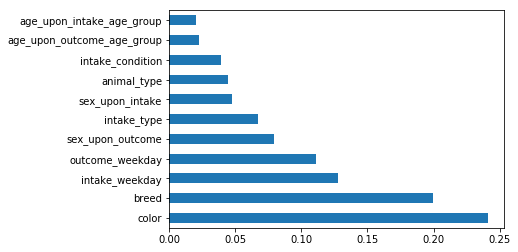

In [41]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_cCodes,y_codes)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_cCodes.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()


In [42]:
#Hence Extracting Final Categorical Features.
X_drop_categorical = X_categorical.drop(["age_upon_intake_age_group","age_upon_outcome_age_group"], axis = 1)
#X_drop_Numeric.head()
finalCatCol = list(X_drop_categorical.columns) #Use These Categorical Columns For Training.



print("Hence, Looking at the above Visualization we infer the list of final Categorical Columns :",finalCatCol )

Hence, Looking at the above Visualization we infer the list of final Categorical Columns : ['animal_type', 'breed', 'color', 'intake_condition', 'intake_type', 'sex_upon_intake', 'intake_weekday', 'sex_upon_outcome', 'outcome_weekday']


**EXTRACTING NUMERICAL FEATURES**

In [43]:
#CHI^2 TEST RUN !
#Selecting NUMERICAL Features
bestfeatures = SelectKBest(score_func=chi2, k="all")
fit1 = bestfeatures.fit(X_nCodes,y_codes)
dfscores1 = pd.DataFrame(fit1.scores_)
dfcolumns1 = pd.DataFrame(X_nCodes.columns)
#concat two dataframes for better visualization 
featureScores1 = pd.concat([dfcolumns1,dfscores1],axis=1)
featureScores1.columns = ['Features','Score']  #naming the dataframe columns
featureScores1["Score"]=featureScores.Score.apply(np.round)
#print(featureScores.nlargest(10,'Score'))  #print 10 best features
featureScores1.sort_values(by=['Score'], ascending=False,inplace=True)
featureScores1

,Features,Score
1,dob_month,98013.0
2,count,41432.0
6,time_in_shelter_days,18944.0
9,outcome_hour,18786.0
5,intake_hour,6319.0
8,outcome_year,2126.0
0,dob_year,1389.0
4,intake_year,493.0
3,intake_month,434.0
10,outcome_number,67.0


[0.10909216 0.09937604 0.         0.06324261 0.02018258 0.13676287
 0.32423163 0.06699985 0.01977422 0.13479473 0.02554331]


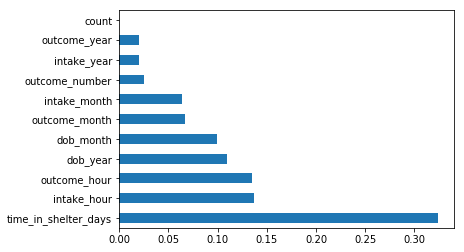

In [44]:
model1 = ExtraTreesClassifier()
model1.fit(X_nCodes,y_codes)
print(model1.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances1 = pd.Series(model1.feature_importances_, index=X_nCodes.columns)
feat_importances1.nlargest(11).plot(kind='barh')
plt.show()



In [45]:
#Hence Extracting Final Numerical Features.
X_drop_Numeric = X_numeric.drop(["count","outcome_year","intake_year"], axis = 1)
#X_drop_Numeric.head()
finalNumericCol = list(X_drop_Numeric.columns) #Use These Numerical Columns For Training.


print("Hence, Looking at the above Visualization we infer the list of final numerical Columns :",finalNumericCol)

Hence, Looking at the above Visualization we infer the list of final numerical Columns : ['dob_year', 'dob_month', 'intake_month', 'intake_hour', 'time_in_shelter_days', 'outcome_month', 'outcome_hour', 'outcome_number']


In [46]:
SelectedFeatures = finalCatCol+finalNumericCol
SelectedFeatures # List of final Selected Features Considered For training the data --

['animal_type',
 'breed',
 'color',
 'intake_condition',
 'intake_type',
 'sex_upon_intake',
 'intake_weekday',
 'sex_upon_outcome',
 'outcome_weekday',
 'dob_year',
 'dob_month',
 'intake_month',
 'intake_hour',
 'time_in_shelter_days',
 'outcome_month',
 'outcome_hour',
 'outcome_number']

In [47]:
#Printing the Original Data with Selected Columns. 
Traindf = X[SelectedFeatures] #The Training DataFrame !! 
display(Traindf.head())
Traindf.isnull().sum() 

,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,intake_weekday,sex_upon_outcome,outcome_weekday,dob_year,dob_month,intake_month,intake_hour,time_in_shelter_days,outcome_month,outcome_hour,outcome_number
0,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,Thursday,Neutered Male,Thursday,2007,7,12,14,0.588194,12,0,1.0
1,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,Friday,Neutered Male,Saturday,2007,7,12,10,1.259722,12,16,2.0
2,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,Friday,Neutered Male,Saturday,2007,7,3,14,1.113889,3,17,3.0
3,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,Wednesday,Neutered Male,Monday,2004,4,4,15,4.970139,4,15,1.0
4,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,Saturday,Neutered Male,Saturday,1997,10,11,9,0.119444,11,11,1.0


animal_type             0
breed                   0
color                   0
intake_condition        0
intake_type             0
sex_upon_intake         1
intake_weekday          0
sex_upon_outcome        1
outcome_weekday         0
dob_year                0
dob_month               0
intake_month            0
intake_hour             0
time_in_shelter_days    0
outcome_month           0
outcome_hour            0
outcome_number          0
dtype: int64

We Can See from Above there is 1 NAN in Sex_upon_intake and Sex_upon_outcome Columns.

**DEFINING MODEL CATBOOSTCLASSIFIER AND EVALUATION,
PREDICTING THE VALUES AND SAVING THE RESULTS**

In [48]:
#HANDLING NULL VALUES AND CATEGORICAL COLUMNS
Traindf.fillna(-999,inplace=True)
X_test_full.fillna(-999,inplace=True)
cate_features_index = np.where(Traindf.dtypes != float)[0]
#SPLITTING THE DATASET FOR TRAINING AND EVALUATION OF THE MODEL
Traindf["outcome_number"] = Traindf["outcome_number"].astype(np.int64)
Traindf["time_in_shelter_days"] = Traindf["time_in_shelter_days"].astype(np.int64)
X1_train, X1_test, y1_train, y1_test = train_test_split(Traindf,y, train_size=0.85,random_state=1234)

#Preparing target variable column
le = LabelEncoder()
le.fit(y1_train)
y1_train_enc = le.transform(y1_train)
y1_test_enc = le.transform(y1_test)

#TRAINING STAGE AND EVALUATION 

#TRAINING THE CATBOOSTCLASSIFIER MODEL ON TRAIN DATA
cat = CatBoostClassifier(one_hot_max_size=7,eval_metric='Accuracy',
                         use_best_model=True,random_seed=42,loss_function='MultiClass')
cat.fit(X1_train,y1_train_enc,cat_features=cate_features_index,eval_set=(X1_test,y1_test_enc))
 
#Checking the Accuracy of the Test Score
#pool = Pool(X1_train, y1_train_enc, cat_features=cate_features_index)
#cv_scores = cv(pool, cat.get_params(), fold_count=10, plot=True)
#print('CV score: {:.5f}'.format(cv_scores['test-Accuracy-mean'].values[-1]))
print('the test accuracy is :{:.6f}'.format(accuracy_score(y1_test_enc,cat.predict(X1_test))))

#PREDICTION AND SAVING RESULTS STAGE 


#PREDICTING VALUES BY USING TEST DATA
X_ready = X_test_full[SelectedFeatures]
X_ready["time_in_shelter_days"] = X_ready["time_in_shelter_days"].astype(np.int64)
pred = cat.predict(X_ready)

#INVERSE LABELENCODING TRANSFORM TO PASS THE ORIGINAL LABELS PREDICTED BY THE MODEL AS A NUMPY ARRAY.
result = list(le.inverse_transform(pred))
out_arr = np.asarray(result)

#Checkpoint to Handle the PREDICTED VALUES passed to .csv file
#print(type(result))
#print(type(out_arr)) 
#print(result)  #You Can Print Predictions to the Console ! 
#print('Train', X1_train.shape, y1_train.shape)
#print('Test', X1_test.shape, y1_test.shape)

#WRITING THE OUTPUT, CONTAINING PREDICTED VALUES BACK TO THE SUBMISSION.CSV FILE.
output = pd.DataFrame({'animal_id_outcome': X_test_full.animal_id_outcome,'outcome_type': out_arr})
output.to_csv('submission.csv', index=False)





/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

0:	learn: 0.5422327	test: 0.5485985	best: 0.5485985 (0)	total: 1.21s	remaining: 20m 5s
1:	learn: 0.5398947	test: 0.5465068	best: 0.5485985 (0)	total: 2.26s	remaining: 18m 48s
2:	learn: 0.5425773	test: 0.5498536	best: 0.5498536 (2)	total: 3.38s	remaining: 18m 43s
3:	learn: 0.5428234	test: 0.5485985	best: 0.5498536 (2)	total: 4.7s	remaining: 19m 31s
4:	learn: 0.5430203	test: 0.5504114	best: 0.5504114 (4)	total: 5.83s	remaining: 19m 21s
5:	learn: 0.5432910	test: 0.5499930	best: 0.5504114 (4)	total: 7s	remaining: 19m 20s
6:	learn: 0.5453583	test: 0.5504114	best: 0.5504114 (4)	total: 8.13s	remaining: 19m 13s
7:	learn: 0.5456044	test: 0.5513875	best: 0.5513875 (7)	total: 9.21s	remaining: 19m 2s
8:	learn: 0.5464658	test: 0.5513875	best: 0.5513875 (7)	total: 10.5s	remaining: 19m 11s
9:	learn: 0.5484101	test: 0.5536187	best: 0.5536187 (9)	total: 11.5s	remaining: 19m 2s
10:	learn: 0.5479917	test: 0.5545949	best: 0.5545949 (10)	total: 12.6s	remaining: 18m 57s
11:	learn: 0.5488531	test: 0.5543160	

92:	learn: 0.5966726	test: 0.6006136	best: 0.6006136 (92)	total: 1m 45s	remaining: 17m 9s
93:	learn: 0.5973125	test: 0.6011714	best: 0.6011714 (93)	total: 1m 46s	remaining: 17m 8s
94:	learn: 0.5974355	test: 0.6006136	best: 0.6011714 (93)	total: 1m 47s	remaining: 17m 7s
95:	learn: 0.5978785	test: 0.6006136	best: 0.6011714 (93)	total: 1m 48s	remaining: 17m 6s
96:	learn: 0.5981000	test: 0.6007530	best: 0.6011714 (93)	total: 1m 50s	remaining: 17m 4s
97:	learn: 0.5983461	test: 0.6007530	best: 0.6011714 (93)	total: 1m 51s	remaining: 17m 3s
98:	learn: 0.5986169	test: 0.6010319	best: 0.6011714 (93)	total: 1m 52s	remaining: 17m 2s
99:	learn: 0.5985184	test: 0.6015897	best: 0.6015897 (99)	total: 1m 53s	remaining: 17m 2s
100:	learn: 0.5986661	test: 0.6017292	best: 0.6017292 (100)	total: 1m 54s	remaining: 16m 59s
101:	learn: 0.5987645	test: 0.6018686	best: 0.6018686 (101)	total: 1m 55s	remaining: 16m 58s
102:	learn: 0.5987153	test: 0.6015897	best: 0.6018686 (101)	total: 1m 56s	remaining: 16m 57s
1

181:	learn: 0.6103318	test: 0.6142797	best: 0.6144192 (179)	total: 3m 22s	remaining: 15m 10s
182:	learn: 0.6104794	test: 0.6145586	best: 0.6145586 (182)	total: 3m 23s	remaining: 15m 9s
183:	learn: 0.6104056	test: 0.6148375	best: 0.6148375 (183)	total: 3m 24s	remaining: 15m 7s
184:	learn: 0.6105533	test: 0.6152559	best: 0.6152559 (184)	total: 3m 25s	remaining: 15m 6s
185:	learn: 0.6106763	test: 0.6148375	best: 0.6152559 (184)	total: 3m 26s	remaining: 15m 4s
186:	learn: 0.6108978	test: 0.6152559	best: 0.6152559 (184)	total: 3m 27s	remaining: 15m 3s
187:	learn: 0.6109963	test: 0.6152559	best: 0.6152559 (184)	total: 3m 29s	remaining: 15m 2s
188:	learn: 0.6109470	test: 0.6151164	best: 0.6152559 (184)	total: 3m 30s	remaining: 15m 1s
189:	learn: 0.6110947	test: 0.6153953	best: 0.6153953 (189)	total: 3m 31s	remaining: 15m
190:	learn: 0.6110455	test: 0.6151164	best: 0.6153953 (189)	total: 3m 32s	remaining: 14m 58s
191:	learn: 0.6110701	test: 0.6149770	best: 0.6153953 (189)	total: 3m 33s	remaini

270:	learn: 0.6152540	test: 0.6163715	best: 0.6163715 (270)	total: 4m 59s	remaining: 13m 24s
271:	learn: 0.6150325	test: 0.6163715	best: 0.6163715 (270)	total: 5m	remaining: 13m 23s
272:	learn: 0.6150817	test: 0.6165109	best: 0.6165109 (272)	total: 5m 1s	remaining: 13m 22s
273:	learn: 0.6153770	test: 0.6162320	best: 0.6165109 (272)	total: 5m 2s	remaining: 13m 21s
274:	learn: 0.6154017	test: 0.6163715	best: 0.6165109 (272)	total: 5m 3s	remaining: 13m 20s
275:	learn: 0.6154755	test: 0.6162320	best: 0.6165109 (272)	total: 5m 4s	remaining: 13m 20s
276:	learn: 0.6154509	test: 0.6160926	best: 0.6165109 (272)	total: 5m 6s	remaining: 13m 19s
277:	learn: 0.6154755	test: 0.6165109	best: 0.6165109 (272)	total: 5m 7s	remaining: 13m 17s
278:	learn: 0.6155985	test: 0.6163715	best: 0.6165109 (272)	total: 5m 8s	remaining: 13m 17s
279:	learn: 0.6155739	test: 0.6166504	best: 0.6166504 (279)	total: 5m 9s	remaining: 13m 16s
280:	learn: 0.6157954	test: 0.6170687	best: 0.6170687 (280)	total: 5m 10s	remainin

359:	learn: 0.6196594	test: 0.6197183	best: 0.6199972 (353)	total: 6m 39s	remaining: 11m 49s
360:	learn: 0.6197578	test: 0.6198578	best: 0.6199972 (353)	total: 6m 40s	remaining: 11m 48s
361:	learn: 0.6195855	test: 0.6199972	best: 0.6199972 (353)	total: 6m 41s	remaining: 11m 47s
362:	learn: 0.6197332	test: 0.6201367	best: 0.6201367 (362)	total: 6m 42s	remaining: 11m 46s
363:	learn: 0.6197824	test: 0.6201367	best: 0.6201367 (362)	total: 6m 43s	remaining: 11m 45s
364:	learn: 0.6198070	test: 0.6201367	best: 0.6201367 (362)	total: 6m 45s	remaining: 11m 44s
365:	learn: 0.6198809	test: 0.6202761	best: 0.6202761 (365)	total: 6m 46s	remaining: 11m 43s
366:	learn: 0.6198563	test: 0.6199972	best: 0.6202761 (365)	total: 6m 47s	remaining: 11m 42s
367:	learn: 0.6199793	test: 0.6202761	best: 0.6202761 (365)	total: 6m 48s	remaining: 11m 41s
368:	learn: 0.6200778	test: 0.6201367	best: 0.6202761 (365)	total: 6m 49s	remaining: 11m 40s
369:	learn: 0.6202008	test: 0.6206945	best: 0.6206945 (369)	total: 6m 

448:	learn: 0.6233018	test: 0.6222284	best: 0.6222284 (418)	total: 8m 21s	remaining: 10m 15s
449:	learn: 0.6233757	test: 0.6226468	best: 0.6226468 (449)	total: 8m 22s	remaining: 10m 14s
450:	learn: 0.6234495	test: 0.6227862	best: 0.6227862 (450)	total: 8m 23s	remaining: 10m 12s
451:	learn: 0.6236956	test: 0.6226468	best: 0.6227862 (450)	total: 8m 24s	remaining: 10m 11s
452:	learn: 0.6236956	test: 0.6229257	best: 0.6229257 (452)	total: 8m 25s	remaining: 10m 10s
453:	learn: 0.6237694	test: 0.6232046	best: 0.6232046 (453)	total: 8m 26s	remaining: 10m 9s
454:	learn: 0.6237448	test: 0.6232046	best: 0.6232046 (453)	total: 8m 28s	remaining: 10m 8s
455:	learn: 0.6239171	test: 0.6232046	best: 0.6232046 (453)	total: 8m 29s	remaining: 10m 7s
456:	learn: 0.6240156	test: 0.6234835	best: 0.6234835 (456)	total: 8m 30s	remaining: 10m 6s
457:	learn: 0.6240156	test: 0.6233440	best: 0.6234835 (456)	total: 8m 31s	remaining: 10m 5s
458:	learn: 0.6241632	test: 0.6234835	best: 0.6234835 (456)	total: 8m 33s	r

538:	learn: 0.6259352	test: 0.6247385	best: 0.6251569 (516)	total: 10m 3s	remaining: 8m 36s
539:	learn: 0.6260091	test: 0.6250174	best: 0.6251569 (516)	total: 10m 5s	remaining: 8m 35s
540:	learn: 0.6259844	test: 0.6250174	best: 0.6251569 (516)	total: 10m 6s	remaining: 8m 34s
541:	learn: 0.6260337	test: 0.6248780	best: 0.6251569 (516)	total: 10m 7s	remaining: 8m 33s
542:	learn: 0.6259598	test: 0.6248780	best: 0.6251569 (516)	total: 10m 8s	remaining: 8m 32s
543:	learn: 0.6260583	test: 0.6248780	best: 0.6251569 (516)	total: 10m 10s	remaining: 8m 31s
544:	learn: 0.6261813	test: 0.6248780	best: 0.6251569 (516)	total: 10m 11s	remaining: 8m 30s
545:	learn: 0.6261813	test: 0.6250174	best: 0.6251569 (516)	total: 10m 12s	remaining: 8m 29s
546:	learn: 0.6263044	test: 0.6250174	best: 0.6251569 (516)	total: 10m 13s	remaining: 8m 28s
547:	learn: 0.6261567	test: 0.6250174	best: 0.6251569 (516)	total: 10m 14s	remaining: 8m 27s
548:	learn: 0.6261567	test: 0.6248780	best: 0.6251569 (516)	total: 10m 15s	

627:	learn: 0.6280518	test: 0.6257147	best: 0.6258541 (623)	total: 11m 45s	remaining: 6m 57s
628:	learn: 0.6280026	test: 0.6255752	best: 0.6258541 (623)	total: 11m 46s	remaining: 6m 56s
629:	learn: 0.6280518	test: 0.6258541	best: 0.6258541 (623)	total: 11m 47s	remaining: 6m 55s
630:	learn: 0.6280272	test: 0.6257147	best: 0.6258541 (623)	total: 11m 48s	remaining: 6m 54s
631:	learn: 0.6280518	test: 0.6257147	best: 0.6258541 (623)	total: 11m 49s	remaining: 6m 53s
632:	learn: 0.6281502	test: 0.6257147	best: 0.6258541 (623)	total: 11m 50s	remaining: 6m 52s
633:	learn: 0.6281502	test: 0.6257147	best: 0.6258541 (623)	total: 11m 52s	remaining: 6m 51s
634:	learn: 0.6280518	test: 0.6255752	best: 0.6258541 (623)	total: 11m 53s	remaining: 6m 49s
635:	learn: 0.6281994	test: 0.6255752	best: 0.6258541 (623)	total: 11m 54s	remaining: 6m 48s
636:	learn: 0.6281994	test: 0.6255752	best: 0.6258541 (623)	total: 11m 55s	remaining: 6m 47s
637:	learn: 0.6281010	test: 0.6255752	best: 0.6258541 (623)	total: 11m

716:	learn: 0.6297746	test: 0.6261330	best: 0.6264119 (664)	total: 13m 24s	remaining: 5m 17s
717:	learn: 0.6297253	test: 0.6264119	best: 0.6264119 (664)	total: 13m 25s	remaining: 5m 16s
718:	learn: 0.6297253	test: 0.6264119	best: 0.6264119 (664)	total: 13m 26s	remaining: 5m 15s
719:	learn: 0.6297253	test: 0.6262725	best: 0.6264119 (664)	total: 13m 27s	remaining: 5m 14s
720:	learn: 0.6297007	test: 0.6265514	best: 0.6265514 (720)	total: 13m 28s	remaining: 5m 12s
721:	learn: 0.6296515	test: 0.6262725	best: 0.6265514 (720)	total: 13m 29s	remaining: 5m 11s
722:	learn: 0.6297007	test: 0.6266908	best: 0.6266908 (722)	total: 13m 30s	remaining: 5m 10s
723:	learn: 0.6297746	test: 0.6262725	best: 0.6266908 (722)	total: 13m 31s	remaining: 5m 9s
724:	learn: 0.6297500	test: 0.6266908	best: 0.6266908 (722)	total: 13m 32s	remaining: 5m 8s
725:	learn: 0.6297746	test: 0.6264119	best: 0.6266908 (722)	total: 13m 34s	remaining: 5m 7s
726:	learn: 0.6297992	test: 0.6268303	best: 0.6268303 (726)	total: 13m 35

805:	learn: 0.6309559	test: 0.6278064	best: 0.6279459 (800)	total: 15m 2s	remaining: 3m 37s
806:	learn: 0.6309559	test: 0.6278064	best: 0.6279459 (800)	total: 15m 4s	remaining: 3m 36s
807:	learn: 0.6309559	test: 0.6276670	best: 0.6279459 (800)	total: 15m 4s	remaining: 3m 35s
808:	learn: 0.6309805	test: 0.6275275	best: 0.6279459 (800)	total: 15m 6s	remaining: 3m 33s
809:	learn: 0.6310297	test: 0.6275275	best: 0.6279459 (800)	total: 15m 7s	remaining: 3m 32s
810:	learn: 0.6310297	test: 0.6275275	best: 0.6279459 (800)	total: 15m 8s	remaining: 3m 31s
811:	learn: 0.6310297	test: 0.6276670	best: 0.6279459 (800)	total: 15m 9s	remaining: 3m 30s
812:	learn: 0.6309559	test: 0.6278064	best: 0.6279459 (800)	total: 15m 10s	remaining: 3m 29s
813:	learn: 0.6310051	test: 0.6278064	best: 0.6279459 (800)	total: 15m 11s	remaining: 3m 28s
814:	learn: 0.6310543	test: 0.6276670	best: 0.6279459 (800)	total: 15m 13s	remaining: 3m 27s
815:	learn: 0.6310051	test: 0.6276670	best: 0.6279459 (800)	total: 15m 14s	re

894:	learn: 0.6321126	test: 0.6280853	best: 0.6285037 (887)	total: 16m 40s	remaining: 1m 57s
895:	learn: 0.6320880	test: 0.6280853	best: 0.6285037 (887)	total: 16m 41s	remaining: 1m 56s
896:	learn: 0.6322111	test: 0.6282248	best: 0.6285037 (887)	total: 16m 42s	remaining: 1m 55s
897:	learn: 0.6322603	test: 0.6280853	best: 0.6285037 (887)	total: 16m 43s	remaining: 1m 53s
898:	learn: 0.6322849	test: 0.6283642	best: 0.6285037 (887)	total: 16m 44s	remaining: 1m 52s
899:	learn: 0.6322603	test: 0.6283642	best: 0.6285037 (887)	total: 16m 45s	remaining: 1m 51s
900:	learn: 0.6323587	test: 0.6282248	best: 0.6285037 (887)	total: 16m 46s	remaining: 1m 50s
901:	learn: 0.6323095	test: 0.6282248	best: 0.6285037 (887)	total: 16m 47s	remaining: 1m 49s
902:	learn: 0.6323341	test: 0.6282248	best: 0.6285037 (887)	total: 16m 48s	remaining: 1m 48s
903:	learn: 0.6322603	test: 0.6283642	best: 0.6285037 (887)	total: 16m 50s	remaining: 1m 47s
904:	learn: 0.6322357	test: 0.6283642	best: 0.6285037 (887)	total: 16m

983:	learn: 0.6333186	test: 0.6282248	best: 0.6286431 (939)	total: 18m 17s	remaining: 17.9s
984:	learn: 0.6333432	test: 0.6280853	best: 0.6286431 (939)	total: 18m 19s	remaining: 16.7s
985:	learn: 0.6333924	test: 0.6280853	best: 0.6286431 (939)	total: 18m 19s	remaining: 15.6s
986:	learn: 0.6334170	test: 0.6280853	best: 0.6286431 (939)	total: 18m 21s	remaining: 14.5s
987:	learn: 0.6334416	test: 0.6280853	best: 0.6286431 (939)	total: 18m 22s	remaining: 13.4s
988:	learn: 0.6335155	test: 0.6278064	best: 0.6286431 (939)	total: 18m 23s	remaining: 12.3s
989:	learn: 0.6335647	test: 0.6278064	best: 0.6286431 (939)	total: 18m 24s	remaining: 11.2s
990:	learn: 0.6335647	test: 0.6279459	best: 0.6286431 (939)	total: 18m 25s	remaining: 10s
991:	learn: 0.6335647	test: 0.6279459	best: 0.6286431 (939)	total: 18m 26s	remaining: 8.92s
992:	learn: 0.6336139	test: 0.6279459	best: 0.6286431 (939)	total: 18m 27s	remaining: 7.8s
993:	learn: 0.6335647	test: 0.6279459	best: 0.6286431 (939)	total: 18m 28s	remainin

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


![Imgur](https://i.imgur.com/DRVG7F3.png)

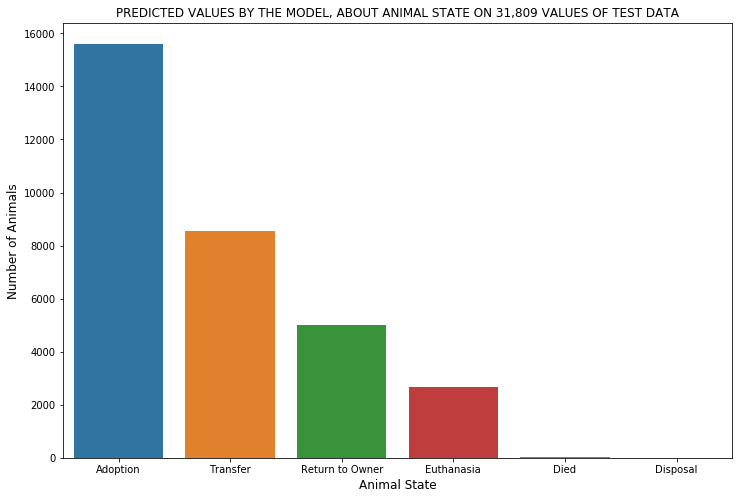

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df1 = pd.read_csv("../input/forplot/Final_Submission.csv")
df1.isnull().sum()
df1["outcome_type"].value_counts() # Predicted Values
#pred_Values = df1["outcome_type"].value_counts(normalize=True) #For relative Frequencies
pred_Values = df1["outcome_type"].value_counts()
plt.figure(figsize=(12,8))
sns.barplot(pred_Values.index, pred_Values.values, alpha=1.0, dodge=False)
plt.title('PREDICTED VALUES BY THE MODEL, ABOUT ANIMAL STATE ON 31,809 VALUES OF TEST DATA')
plt.ylabel('Number of Animals', fontsize=12)
plt.xlabel('Animal State', fontsize=12)
plt.show()

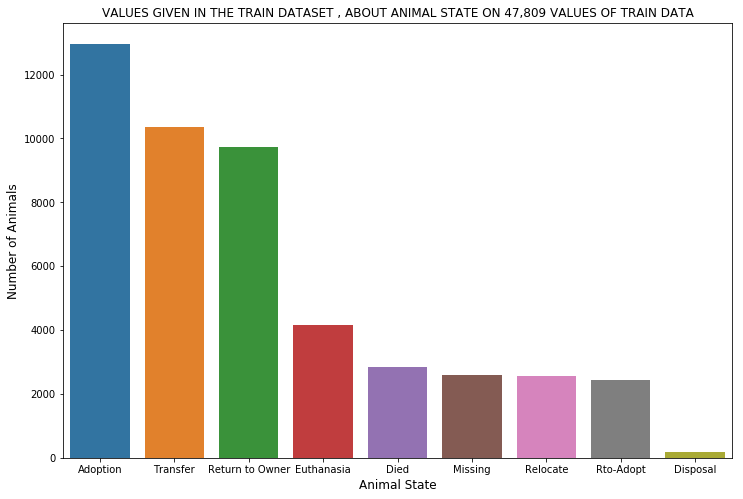

In [50]:
X2 = pd.read_csv("../input/animalstate-awc/train.csv")
X2.head()
X2["outcome_type"].value_counts() #Original DataSet Target Values
#X2["outcome_type"].value_counts(dropna=False)
original_Values = X2["outcome_type"].value_counts()
plt.figure(figsize=(12,8))
sns.barplot(original_Values.index, original_Values.values, alpha=1.0, dodge=False)
plt.title('VALUES GIVEN IN THE TRAIN DATASET , ABOUT ANIMAL STATE ON 47,809 VALUES OF TRAIN DATA')
plt.ylabel('Number of Animals', fontsize=12)
plt.xlabel('Animal State', fontsize=12)
plt.show()


**ANALYSIS AND DISCUSSION ON RESULTS**

1. On Seeing the above two visualization, you can clearly form out a picture how much the trained model is aligned to the given data. 

2. Variation in Plots is beacuse of less values in test data(31,809 approx.) in comparison to train data(47,809 approx.) 

3. About Data set you can clearly say how unbalanced the data is for few values like( "missing", "Died", "Relocate", "RTO-Adopt", "Disposal"). 

4. Rest all preidcted values are likely to be aligned with training data. Clearly ! Though we can say many animals went for Adoption after their period in the Welfare Center. 

5. Well Because of missing data in test dataset, few values cannot be predicted by the model clearly because of no data given for such scenarios. which limits the accuracy of model to 65%. Moreover efficiency over 75% is very difficult to achieve in such unbalanced data.

6. But still the Model let's you classify the category of animal state, provided you pass the required params. 

7. I see this as a advantage and an application in field of Medical Healthcare for animals and will let the other veterinary practitioners to comment on the outcome_type of animal state, so as to provide better medical facilities and extra care to specific category of animals.